In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf

# Add this code at the beginning of your script
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
import zipfile

# Specify the path to the ZIP file you want to unzip
zip_file_path = 'animals.zip'

# Specify the directory where you want to extract the contents
extracted_dir = '/content/drive/MyDrive/DS_9000'

# Create a ZipFile object and open the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents of the ZIP file to the specified directory
    zip_ref.extractall(extracted_dir)

print(f'Contents of {zip_file_path} have been extracted to {extracted_dir}')

Contents of animals.zip have been extracted to /content/drive/MyDrive/DS_9000


In [1]:
!pip install split-folders

In [11]:
import splitfolders
splitfolders.ratio('/content/drive/MyDrive/DS_9000/animals/', output="/content/drive/MyDrive/DS_9000/animals_class/", seed=1337, ratio=(0.8, 0.2))

Copying files: 1448 files [00:25, 56.55 files/s]


## Using MobileNet

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import csv
from hyperopt import fmin, tpe, hp
from hyperopt.pyll.base import scope
from tqdm import tqdm

In [4]:
# Generating images for the Training set
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
# Generating images for the Test set
test_datagen = ImageDataGenerator(rescale=1./255)
# Creating training set
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/DS_9000/animals_class/train/',
                                                 target_size=(64, 64),
                                                 batch_size=16,
                                                 class_mode='binary')
# Creating the Test set
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/DS_9000/animals_class/val/',
                                            target_size=(64, 64),
                                            batch_size=16,
                                            class_mode='binary')

# Define a function that contains your Keras model and training procedure
def train_keras_model(params):
    # Extract hyperparameters
    learning_rate = params['learning_rate']

    # Load pre-trained MobileNetV2 model
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

    # Freeze the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False

    # Create a new model on top of MobileNetV2
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification (domestic or wild)

    # Compile the model with the specified learning rate
    opt = Adam(learning_rate=learning_rate)
    print("\n\t Your learning rate is %s\n" % str(learning_rate))
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    # Callback for model checkpoint
    checkpoint = ModelCheckpoint(
        filepath="/content/drive/MyDrive/DS_9000/animals_class/saved_model.h5",
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    callbacks = [checkpoint]

    # Train the model
    train_history = model.fit(training_set, steps_per_epoch=len(training_set), epochs=7,
                                   validation_data=test_set, callbacks=callbacks)

    # Return the validation accuracy as the objective to be minimized
    val_accuracy = max(train_history.history['val_accuracy'])
    return -val_accuracy  # Negative value because fmin minimizes the objective

# Define a search space for hyperparameters using Hyperopt's hp functions
space = {
    'learning_rate': hp.loguniform('learning_rate', -10, -2),  # Logarithmic search space for learning rate
    }

# Use Hyperopt to search for the best hyperparameters
best = fmin(fn=train_keras_model, space=space, algo=tpe.suggest, max_evals=10)  # Adjust max_evals as needed

print("Best Hyperparameters:")
print(best)


Streaming output truncated to the last 5000 lines.
73/73 [==============================] - 16s 225ms/step - loss: 0.3981 - accuracy: 0.8178 - val_loss: 0.4612 - val_accuracy: 0.7655

Epoch 7/7

73/73 [==============================] - 15s 201ms/step - loss: 0.3729 - accuracy: 0.8333 - val_loss: 0.4597 - val_accuracy: 0.7690


	 Your learning rate is 0.0006730274047902109

Epoch 1/7

73/73 [==============================] - 19s 224ms/step - loss: 0.6725 - accuracy: 0.6960 - val_loss: 0.4951 - val_accuracy: 0.7517

Epoch 2/7

73/73 [==============================] - 16s 216ms/step - loss: 0.4378 - accuracy: 0.8092 - val_loss: 0.4703 - val_accuracy: 0.8000

Epoch 3/7

73/73 [==============================] - 14s 193ms/step - loss: 0.4032 - accuracy: 0.8221 - val_loss: 0.4696 - val_accuracy: 0.7966

Epoch 4/7

73/73 [==============================] - 16s 217ms/step - loss: 0.3576 - accuracy: 0.8402 - val_loss: 0.4573 - val_accuracy: 0.8172

Epoch 5/7

73/73 [==============================

**Main Model With Batch Normalization**

In [5]:
# Now that we found the best hyperparameters, we will train our final model using the best hyperparameters.

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

# Set default values for parameters
epochs = 50         # Default number of epochs
learning_rate = 0.0031301075118151454  # Default learning rate

# Generating images for the Training set
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
# Generating images for the Test set
test_datagen = ImageDataGenerator(rescale=1./255)
# Creating training set
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/DS_9000/animals_class/train/',
                                                 target_size=(128, 128),
                                                 batch_size=16,
                                                 class_mode='binary')
# Creating the Test set
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/DS_9000/animals_class/val/',
                                            target_size=(128, 128),
                                            batch_size=16,
                                            class_mode='binary')

# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of MobileNetV2
model = models.Sequential()
model.add(base_model)

# Fully Connected Layers with Dropout and Batch Normalization
model.add(layers.GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())

# Output Layer
model.add(Dense(1, activation='sigmoid'))


# Compile the model
opt = Adam(learning_rate=learning_rate)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

try:
    model.summary()
except:
    print("summary printout failed")

checkpoint = ModelCheckpoint(
    filepath="/content/drive/MyDrive/DS_9000/animals_class/saved_model.h5",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
callbacks = [checkpoint]
train_history = model.fit(training_set, steps_per_epoch=len(training_set), epochs=epochs, validation_data=test_set, callbacks=callbacks)

model.save("/content/drive/MyDrive/DS_9000/animals_class/model.h5")

with open('/content/drive/MyDrive/DS_9000/animal_training_history.csv', 'w') as f:
    w = csv.writer(f)
    w.writerow(train_history.history.keys())
    w.writerows(zip(*train_history.history.values()))

Found 1158 images belonging to 2 classes.
Found 290 images belonging to 2 classes.
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
 0 (GlobalAveragePooling2D)                                      
                                                                 
 dense_20 (Dense)            (None, 64)                81984     
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dropout_10 (Dropout)        (None, 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
val_accuracy = round(max(train_history.history['val_accuracy']),4)
print("The maximum validation accuracy is", val_accuracy*100,"%")

The maximum validation accuracy is 95.86 %


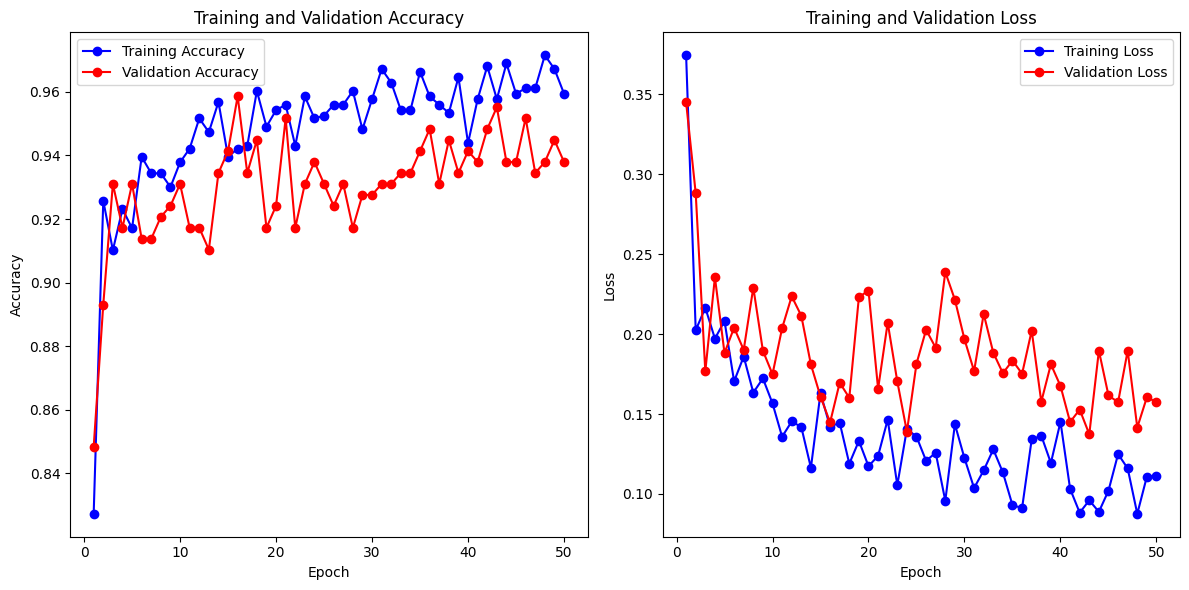

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv('/content/drive/MyDrive/DS_9000/animal_training_history.csv')

# Add a new column 'epoch' starting from 1
df['epoch'] = range(1, len(df) + 1)

# Plot training accuracy and validation accuracy against epoch
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['accuracy'], label='Training Accuracy', marker='o', linestyle='-', color='b')
plt.plot(df['epoch'], df['val_accuracy'], label='Validation Accuracy', marker='o', linestyle='-', color='r')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training loss and validation loss against epoch
plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['loss'], label='Training Loss', marker='o', linestyle='-', color='b')
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss', marker='o', linestyle='-', color='r')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Evaluating the Test Set

In [27]:
from tensorflow.keras.models import load_model

test_data_dir = '/content/drive/MyDrive/DS_9000/animals_class/test'

# Evaluate the model on the test set
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary',
    shuffle=False  # Ensure predictions match actual labels
)

# Load your trained CNN model
model = load_model('/content/drive/MyDrive/DS_9000/animals_class/model.h5')

# Make predictions on the test set
y_pred = model.predict(test_generator)

# Extract true labels from the generator
y_true = test_generator.classes


Found 160 images belonging to 2 classes.
10/10 [==============================] - 2s 85ms/step


In [28]:
from sklearn.metrics import roc_auc_score

# Compute AUC
auc = roc_auc_score(y_true, y_pred)
print(f'AUC on the test set: {auc}')

AUC on the test set: 0.9221875


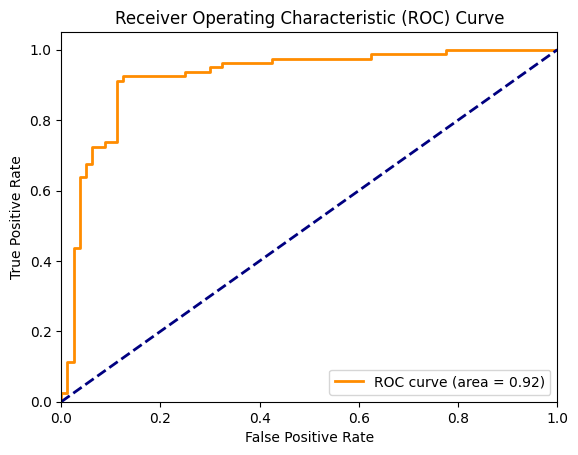

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [36]:
# Calculate predicted labels based on thresholds
y_pred2 = (y_pred >= thresholds[np.argmax(tpr - fpr)]).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred2)

print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 90.00%


In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming y_true and y_pred are your true and predicted labels, respectively
precision = precision_score(y_true, y_pred2)
recall = recall_score(y_true, y_pred2)
f1 = f1_score(y_true, y_pred2)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.8810
Recall: 0.9250
F1 Score: 0.9024


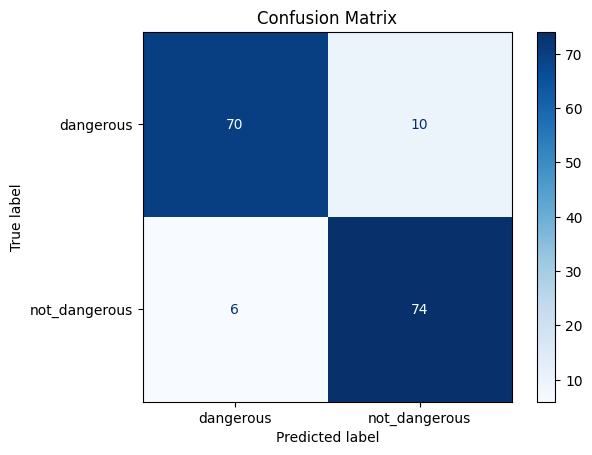

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred2, labels=np.unique(y_true))
classes = test_generator.class_indices.keys()

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp2.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()